14:30:51-INFO-Path for logging: C:\Users\fpenaherrera_vaca\.oemof\log_files\oemof_example.log
14:30:51-INFO-Initialize the energy system
14:30:51-INFO-Create oemof objects
14:30:51-INFO-Optimise the energy system


14:30:53-INFO-Solve the optimization problem
14:30:58-INFO-Optimization successful...
14:30:58-INFO-Store the energy system with the results.
14:31:00-INFO-**** The script can be divided into two parts here.
14:31:00-INFO-Restore the energy system and the results.
14:31:00-INFO-Restoring attributes will overwrite existing attributes.

********* State of Charge (slice) *********
variable_name        storage_content
2012-02-25 08:00:00     1.161744e+06
2012-02-25 09:00:00     8.727082e+05
2012-02-25 10:00:00     6.755412e+05
2012-02-25 11:00:00     5.108711e+05
2012-02-25 12:00:00     3.350903e+05
2012-02-25 13:00:00     1.104116e+05
2012-02-25 14:00:00     0.000000e+00
2012-02-25 15:00:00     0.000000e+00
2012-02-25 16:00:00     0.000000e+00
2012-02-25 17:00:00     0.000000e+00



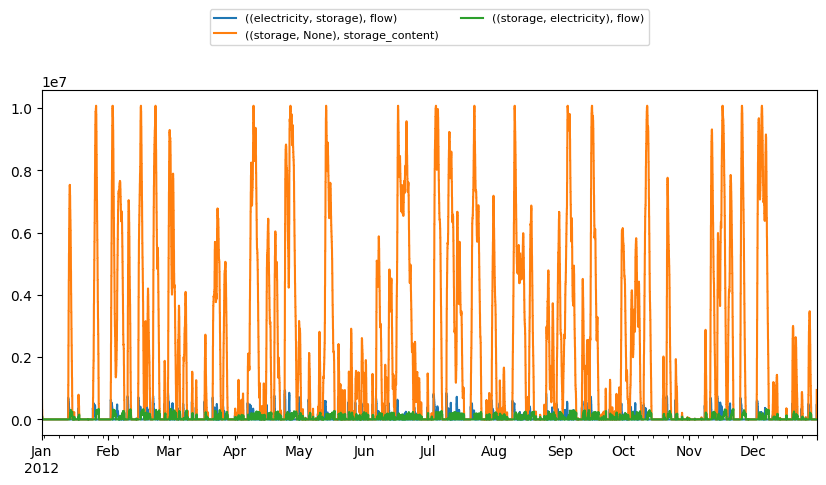

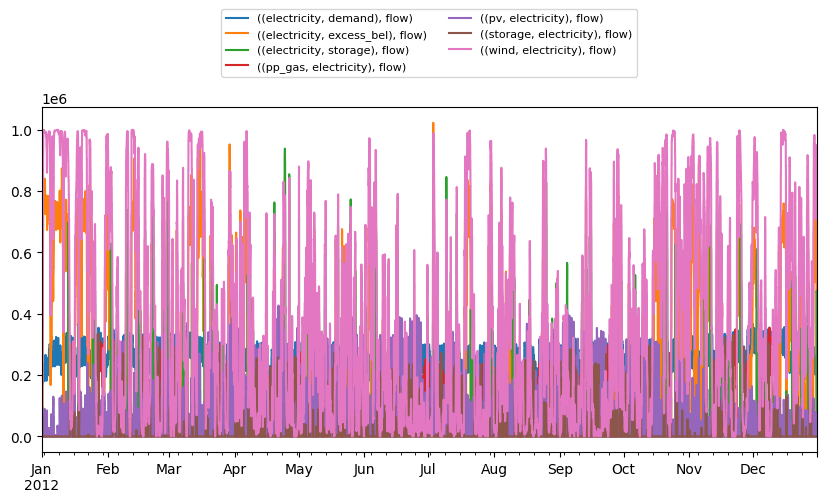

********* Meta results *********
{'objective': 6064825858.202132,
 'problem': {'Lower bound': 6064825858.20213,
             'Name': 'unknown',
             'Number of constraints': 35041,
             'Number of nonzeros': 105122,
             'Number of objectives': 1,
             'Number of variables': 61321,
             'Sense': <ProblemSense.minimize: 'minimize'>,
             'Upper bound': 6064825858.20213},
 'solver': {'Error rc': 0,
            'Statistics': {'Black box': <undefined>,
                           'Branch and bound': {'Number of bounded subproblems': <pyomo.opt.results.container.ScalarData object at 0x000001C221DB58B0>,
                                                'Number of created subproblems': <pyomo.opt.results.container.ScalarData object at 0x000001C221DB58E0>}},
            'Status': <SolverStatus.ok: 'ok'>,
            'Termination condition': <TerminationCondition.optimal: 'optimal'>,
            'Time': 3.5773868560791016}}

********* Main results *

In [6]:
# -*- coding: utf-8 -*-

"""
General description
-------------------

A basic example to show how to model a simple energy system with oemof.solph.

The following energy system is modeled:

.. code-block:: text

                     input/output  bgas     bel
                         |          |        |
                         |          |        |
     wind(FixedSource)   |------------------>|
                         |          |        |
     pv(FixedSource)     |------------------>|
                         |          |        |
     rgas(Commodity)     |--------->|        |
                         |          |        |
     demand(Sink)        |<------------------|
                         |          |        |
                         |          |        |
     pp_gas(Transformer) |<---------|        |
                         |------------------>|
                         |          |        |
     storage(Storage)    |<------------------|
                         |------------------>|


Data
----
basic_example.csv


Installation requirements
-------------------------
This example requires oemof.solph (v0.5.x), install by:

    pip install oemof.solph[examples]

License
-------
`MIT license <https://github.com/oemof/oemof-solph/blob/dev/LICENSE>`_
"""
###########################################################################
# imports
###########################################################################

import logging
import os
import pprint as pp
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from oemof.tools import logger

from oemof.solph import EnergySystem
from oemof.solph import Model
from oemof.solph import buses
from oemof.solph import components as cmp
from oemof.solph import create_time_index
from oemof.solph import flows
from oemof.solph import helpers
from oemof.solph import processing
from oemof.solph import views


def main():
    # *************************************************************************
    # ********** PART 1 - Define and optimise the energy system ***************
    # *************************************************************************

    # Read data file

    filename = os.path.join(os.getcwd(), "basic_example.csv")
    try:
        data = pd.read_csv(filename)
    except FileNotFoundError:
        msg = "Data file not found: {0}. Only one value used!"
        warnings.warn(msg.format(filename), UserWarning)
        data = pd.DataFrame({"pv": [0.3], "wind": [0.6], "demand_el": [500]})

    solver = "glpk"  # 'glpk', 'gurobi',....
    debug = False  # Set number_of_timesteps to 3 to get a readable lp-file.
    number_of_time_steps = len(data)
    solver_verbose = False  # show/hide solver output

    # initiate the logger (see the API docs for more information)
    logger.define_logging(
        logfile="oemof_example.log",
        screen_level=logging.INFO,
        file_level=logging.INFO,
    )

    logging.info("Initialize the energy system")
    date_time_index = create_time_index(2012, number=number_of_time_steps)

    energysystem = EnergySystem(
        timeindex=date_time_index, infer_last_interval=False
    )

    ##########################################################################
    # Create oemof object
    ##########################################################################

    logging.info("Create oemof objects")

    # The bus objects were assigned to variables which makes it easier to
    # connect components to these buses (see below).

    # create natural gas bus
    bgas = buses.Bus(label="natural_gas")

    # create electricity bus
    bel = buses.Bus(label="electricity")

    # adding the buses to the energy system
    energysystem.add(bgas, bel)

    # create excess component for the electricity bus to allow overproduction
    energysystem.add(cmp.Sink(label="excess_bel", inputs={bel: flows.Flow()}))

    # create source object representing the gas commodity (annual limit)
    energysystem.add(
        cmp.Source(
            label="rgas",
            outputs={bgas: flows.Flow()},
        )
    )

    # create fixed source object representing wind power plants
    energysystem.add(
        cmp.Source(
            label="wind",
            outputs={bel: flows.Flow(fix=data["wind"], nominal_value=1000000)},
        )
    )

    # create fixed source object representing pv power plants
    energysystem.add(
        cmp.Source(
            label="pv",
            outputs={bel: flows.Flow(fix=data["pv"], nominal_value=582000)},
        )
    )

    # create simple sink object representing the electrical demand
    energysystem.add(
        cmp.Sink(
            label="demand",
            inputs={bel: flows.Flow(fix=data["demand_el"], nominal_value=1)},
        )
    )

    # create simple transformer object representing a gas power plant
    energysystem.add(
        cmp.Transformer(
            label="pp_gas",
            inputs={bgas: flows.Flow()},
            outputs={bel: flows.Flow(nominal_value=10e10, variable_costs=50)},
            conversion_factors={bel: 0.58},
        )
    )

    # create storage object representing a battery
    storage = cmp.GenericStorage(
        nominal_storage_capacity=10077997,
        label="storage",
        inputs={bel: flows.Flow(nominal_value=10077997 / 6)},
        outputs={
            bel: flows.Flow(nominal_value=10077997 / 6, variable_costs=0.001)
        },
        loss_rate=0.00,
        initial_storage_level=None,
        inflow_conversion_factor=1,
        outflow_conversion_factor=0.8,
    )

    energysystem.add(storage)

    ##########################################################################
    # Optimise the energy system and plot the results
    ##########################################################################

    logging.info("Optimise the energy system")

    # initialise the operational model
    model = Model(energysystem)

    # This is for debugging only. It is not(!) necessary to solve the problem
    # and should be set to False to save time and disc space in normal use. For
    # debugging the timesteps should be set to 3, to increase the readability
    # of the lp-file.
    if debug:
        filename = os.path.join(
            helpers.extend_basic_path("lp_files"), "basic_example.lp"
        )
        logging.info("Store lp-file in {0}.".format(filename))
        model.write(filename, io_options={"symbolic_solver_labels": True})

    # if tee_switch is true solver messages will be displayed
    logging.info("Solve the optimization problem")
    model.solve(solver=solver, solve_kwargs={"tee": solver_verbose})

    logging.info("Store the energy system with the results.")

    # The processing module of the outputlib can be used to extract the results
    # from the model transfer them into a homogeneous structured dictionary.

    # add results to the energy system to make it possible to store them.
    energysystem.results["main"] = processing.results(model)
    energysystem.results["meta"] = processing.meta_results(model)

    # The default path is the '.oemof' folder in your $HOME directory.
    # The default filename is 'es_dump.oemof'.
    # You can omit the attributes (as None is the default value) for testing
    # cases. You should use unique names/folders for valuable results to avoid
    # overwriting.

    # store energy system with results
    energysystem.dump(dpath=None, filename=None)

    # *************************************************************************
    # ********** PART 2 - Processing the results ******************************
    # *************************************************************************

    logging.info("**** The script can be divided into two parts here.")
    logging.info("Restore the energy system and the results.")
    energysystem = EnergySystem()
    energysystem.restore(dpath=None, filename=None)

    # define an alias for shorter calls below (optional)
    results = energysystem.results["main"]
    storage = energysystem.groups["storage"]

    # print a time slice of the state of charge
    print("")
    print("********* State of Charge (slice) *********")
    print(
        results[(storage, None)]["sequences"][
            datetime(2012, 2, 25, 8, 0, 0) : datetime(2012, 2, 25, 17, 0, 0)
        ]
    )
    print("")

    # get all variables of a specific component/bus
    custom_storage = views.node(results, "storage")
    electricity_bus = views.node(results, "electricity")

    # plot the time series (sequences) of a specific component/bus

    fig, ax = plt.subplots(figsize=(10, 5))
    custom_storage["sequences"].plot(
        ax=ax, kind="line", drawstyle="steps-post"
    )
    plt.legend(
        loc="upper center",
        prop={"size": 8},
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
    )
    fig.subplots_adjust(top=0.8)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    electricity_bus["sequences"].plot(
        ax=ax, kind="line", drawstyle="steps-post"
    )
    plt.legend(
        loc="upper center", prop={"size": 8}, bbox_to_anchor=(0.5, 1.3), ncol=2
    )
    fig.subplots_adjust(top=0.8)
    plt.show()

    # print the solver results
    print("********* Meta results *********")
    pp.pprint(energysystem.results["meta"])
    print("")

    # print the sums of the flows around the electricity bus
    print("********* Main results *********")
    print(electricity_bus["sequences"].sum(axis=0))



main()

In [5]:
from pyomo.environ import *

# create a model
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(expr = 40*model.x + 30*model.y, sense=maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
results = SolverFactory('glpk').solve(model)
results.write()
if results.solver.status:
    model.pprint()

# display solution
print('\nProfit = ', model.profit())

print('\nDecision Variables')
print('x = ', model.x())
print('y = ', model.y())

print('\nConstraints')
print('Demand  = ', model.demand())
print('Labor A = ', model.laborA())
print('Labor B = ', model.laborB())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 2
  Number of nonzeros: 5
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.037001609802246094
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------